# Modelling

## Import libraries

In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import TimeSeriesSplit

from sklearn.ensemble import HistGradientBoostingRegressor

from sklearn.pipeline import Pipeline

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.metrics import mean_absolute_error

pd.options.display.float_format = '{:.2f}'.format

import warnings
warnings.filterwarnings("ignore")

import pickle

## Load the data

In [2]:
x = pd.read_pickle("../data/x_final.pickle")
y = pd.read_pickle("../data/y_final.pickle")

## Modeling for one product and store

### First step is to see what a good model looks like for just one single product in one store. Once this process is defined it will be easier to scale it for all the products and stores.

In [3]:
# Let's choose one product at random
x = x.loc[(x["store_id"] == "CA_3") & (x["item_id"] == "FOODS_3_586")]
x

,date,store_id,item_id,sales_mvgmean_8,sales_mvgmean_7,sales_mvgmean_9,sales_mvgmean_6,sales_mvgmean_2,sales_mvgmean_10,sales_mvgmean_3,...,sell_price_lag_3,sell_price_lag_7,sell_price_lag_5,stock_outage_3_lag_1,stock_outage_7_lag_1,stock_outage_15_lag_1,event_name_1_no_event,event_type_1_no_event,event_type_1_te,event_name_1_te
7343,2013-01-16,CA_3,FOODS_3_586,9.12,9.14,9.33,9.33,11.50,9.10,8.33,...,1.48,1.48,1.48,0.00,0.00,0.00,1.00,1.00,28.85,28.85
7344,2013-01-17,CA_3,FOODS_3_586,8.75,8.86,8.78,8.17,9.00,9.00,9.67,...,1.48,1.48,1.48,0.00,0.00,0.00,1.00,1.00,28.85,28.85
7345,2013-01-18,CA_3,FOODS_3_586,9.38,8.86,9.22,9.17,9.50,9.20,10.33,...,1.48,1.48,1.48,0.00,0.00,0.00,1.00,1.00,28.85,28.85
7346,2013-01-19,CA_3,FOODS_3_586,8.75,9.00,9.22,8.67,10.50,9.10,9.00,...,1.48,1.48,1.48,0.00,0.00,0.00,1.00,1.00,28.85,28.85
7347,2013-01-20,CA_3,FOODS_3_586,9.50,9.29,9.22,10.50,10.50,9.60,11.33,...,1.48,1.48,1.48,0.00,0.00,0.00,1.00,1.00,28.85,28.85
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8387,2015-11-26,CA_3,FOODS_3_586,7.38,7.00,7.11,6.83,5.00,7.10,6.00,...,1.58,1.58,1.58,0.00,0.00,0.00,0.00,0.00,28.35,28.87
8388,2015-11-27,CA_3,FOODS_3_586,7.88,7.86,8.11,8.50,9.50,7.80,8.00,...,1.58,1.58,1.58,0.00,0.00,0.00,1.00,1.00,28.85,28.85
8389,2015-11-28,CA_3,FOODS_3_586,8.12,8.71,8.11,8.50,12.00,8.30,9.67,...,1.58,1.58,1.58,0.00,0.00,0.00,1.00,1.00,28.85,28.85
8390,2015-11-29,CA_3,FOODS_3_586,8.38,8.14,7.89,8.00,8.00,7.90,10.00,...,1.58,1.58,1.58,0.00,0.00,0.00,1.00,1.00,28.85,28.85


In [4]:
# Get the sales target variable for these specific indexes
y = y[y.index.isin(x.index)]
y

7343     6
7344    13
7345     8
7346    13
7347    13
        ..
8387    14
8388    10
8389     6
8390     7
8391     3
Name: sales, Length: 1049, dtype: int64

### Prepare for modelling

In [5]:
# Feature to be modelled (exclude date, store_id and item_id)
var_model = x.columns.to_list()[3:]

#### In order to introduce cross-validation in time-series datasets it is necessary to carry out a different format of the cross-validation concept. For this case, we are going to use 3 different validation data splits which are 8 days long each one.

In [6]:
# The test_size should be similar to the time frame we want to predict when
# the model is finished
time_cv = TimeSeriesSplit(n_splits=3, test_size=8) 

### Hyperparameter tuning

In [50]:
# Using the default option of LightGBM works very well

pipe = Pipeline([("algorithm", HistGradientBoostingRegressor())])

grid = [    {"algorithm": [HistGradientBoostingRegressor()]
            #  "algorithm__learning_rate": [0.01, 0.025, 0.05, 0.1],
            #  "algorithm__max_iter": [50, 100, 200],
            #  "algorithm__max_depth": [5, 10, 20],
            #  "algorithm__min_samples_leaf": [500],
            #  "algorithm__scoring": ["neg_mean_absolute_error"],
            #  "algorithm__l2_regularization": [0, 0.25, 0.5, 0.75, 1],
             }
            # More algorithms could be added here if we wanted to test more

]

#### Apply random search

In [51]:
random_search = RandomizedSearchCV(estimator = pipe,
                                   param_distributions = grid, 
                                   n_iter = 25, 
                                   cv = time_cv, 
                                   scoring = "neg_mean_absolute_error", 
                                   verbose = 0,
                                   n_jobs = -1)

model = random_search.fit(x[var_model], y)

pd.DataFrame(random_search.cv_results_).sort_values(by="rank_test_score")

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_algorithm,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.59,0.02,0.00,0.00,HistGradientBoostingRegressor(),{'algorithm': HistGradientBoostingRegressor()},-4.24,-2.01,-3.44,-3.23,0.92,1


In [53]:
# Get the best model from the random search
final_model = model.best_estimator_.fit(x[var_model],y)

In [54]:
# Predict the sales with the final model for the given product
prediction = final_model.predict(x[var_model])
prediction

array([ 7.37421835, 10.71937997,  9.72968981, ...,  7.33490276,
        7.84192341,  5.81088683])

In [55]:
# Create dataframe concatenating the actual value and the predictions
temp = pd.concat([x["date"].reset_index(drop=True), y.reset_index(drop=True), pd.Series(prediction, name="prediction")], axis=1).set_index("date")
temp

,sales,prediction
date,,
2013-01-16,6,7.37
2013-01-17,13,10.72
2013-01-18,8,9.73
2013-01-19,13,11.34
2013-01-20,13,11.28
...,...,...
2015-11-26,14,11.10
2015-11-27,10,10.12
2015-11-28,6,7.33


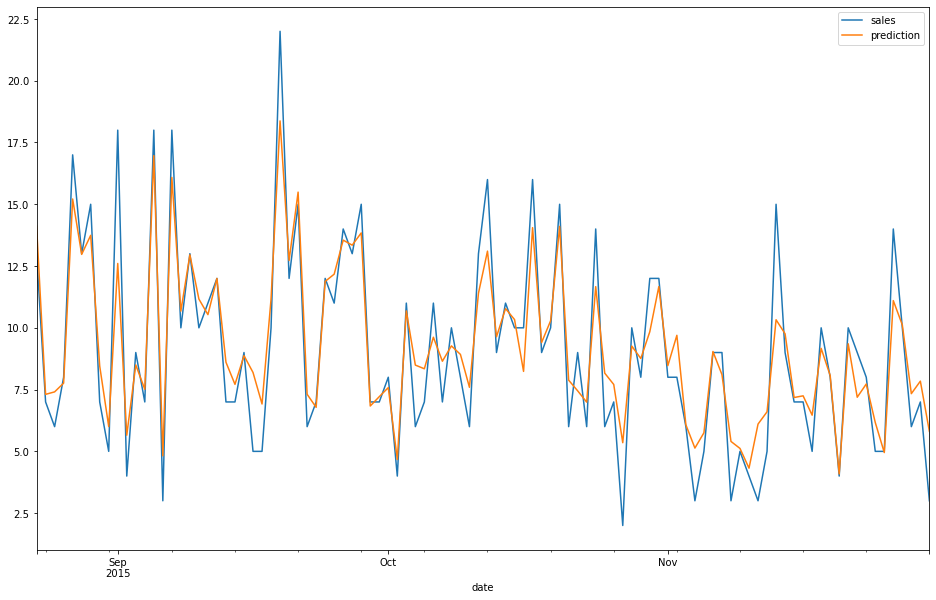

In [56]:
temp.tail(100).plot(figsize = (16,10));